Example: find top 5 in pagerank in a layer, then check over time pagerank values.

# Enron (loading)

In [1]:
import re
import pandas as pd
import altair as alt
import raphtory as rty
#from raphtory import algorithms
from email.utils import parsedate_to_datetime, parsedate
from datetime import timezone, datetime
from time import mktime

## Ingesting the data

In [2]:
csv = pd.read_csv('/data-restricted/home/cheick_ba/data_on_nas/raphtory/data/enrondata/archive.zip', compression="zip")
emails = csv['message']

In [3]:
def extract_cc_list(text):
    cc_cut = text.split("Cc: ")
    
    if len(cc_cut) > 1:
        cc_section = cc_cut[1].split(":")[0]
        cc_emails = re.findall(r'\S+@\S+', cc_section)
        return list(map(lambda email: email.split('@')[0], cc_emails))
    else:
        return 

def extract_bcc_list(text):
    bcc_cut = text.split("Bcc: ")

    if len(bcc_cut) > 1:
        bcc_section = bcc_cut[1].split(":")[0]
        bcc_emails = re.findall(r'\S+@\S+', bcc_section)
        return list(map(lambda email: email.split('@')[0], bcc_emails))
    else:
        return

extract_sender = lambda text: text.split("From: ")[1].split("@")[0]
extract_recipient = lambda text: text.split("To: ")[1].split("@")[0]
extract_date = lambda text: text.split("Date: ")[1].split("\n")[0]

enron = pd.DataFrame()
enron['src'] = emails.apply(extract_sender)
enron['dst'] = emails.apply(extract_recipient)
enron['time'] = emails.apply(extract_date)
enron['type'] = 'direct'
enron['message'] = emails

enron_cc = enron.loc[:, ['src', 'time', 'message']]
enron_cc['dst'] = emails.apply(extract_cc_list)     
enron_cc = enron_cc.explode('dst').dropna()
enron_cc['type'] = 'cc'

enron_bcc = enron.loc[:, ['src', 'time', 'message']]
enron_bcc['dst'] = emails.apply(extract_bcc_list)     
enron_bcc = enron_bcc.explode('dst').dropna()
enron_bcc['type'] = 'bcc'

enron = pd.concat([enron, enron_cc, enron_bcc])
enron

,src,dst,time,type,message
0,phillip.allen,tim.belden,"Mon, 14 May 2001 16:39:00 -0700 (PDT)",direct,Message-ID: <18782981.1075855378110.JavaMail.e...
1,phillip.allen,john.lavorato,"Fri, 4 May 2001 13:51:00 -0700 (PDT)",direct,Message-ID: <15464986.1075855378456.JavaMail.e...
2,phillip.allen,leah.arsdall,"Wed, 18 Oct 2000 03:00:00 -0700 (PDT)",direct,Message-ID: <24216240.1075855687451.JavaMail.e...
3,phillip.allen,randall.gay,"Mon, 23 Oct 2000 06:13:00 -0700 (PDT)",direct,Message-ID: <13505866.1075863688222.JavaMail.e...
4,phillip.allen,greg.piper,"Thu, 31 Aug 2000 05:07:00 -0700 (PDT)",direct,Message-ID: <30922949.1075863688243.JavaMail.e...
...,...,...,...,...,...
517323,john.zufferli,kimberly.hillis,"Wed, 13 Jun 2001 07:19:27 -0700 (PDT)",bcc,Message-ID: <15205398.1075842036502.JavaMail.e...
517335,john.zufferli,rob.milnthorp,"Thu, 24 Jan 2002 14:00:42 -0800 (PST)",bcc,Message-ID: <20351161.1075842028492.JavaMail.e...
517352,john.zufferli,rob.milnthorp,"Fri, 18 Jan 2002 06:52:25 -0800 (PST)",bcc,Message-ID: <12099366.1075842028905.JavaMail.e...
517371,john.zufferli,jzufferli,"Mon, 7 Jan 2002 13:01:08 -0800 (PST)",bcc,Message-ID: <537849.1075842029343.JavaMail.eva...


# This is slower, but more clear imho

In [4]:
raw_graph = rty.Graph()

for idx, record in enron.iterrows():
    raw_graph.add_edge(timestamp = record['time'], src=record['src'], dst=record['dst'], 
                       properties={'message': record['message']}, layer=record['type'])
    
g = raw_graph.window(start='2000-01-01 00:00:00', end='2003-01-01 00:00:00')
print(g)

# we can make parameters explicit

Graph(number_of_edges=156543, number_of_vertices=52864, earliest_time=946684800000, latest_time=1041379200000)

In [5]:
for e in g.edges():
    print(e)
    break

Edge(source=phillip.allen, target=tim.belden, earliest_time=947500140000, latest_time=989883540000, properties={message : Message-ID: <12792381.1075858637829.JavaMail.evans@thyme>
Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
From: phillip.allen@enron.com
To: tim.belden@enron.com
Subject: 
Mime-Version: 1.0
Content-Type: text/plain; charset=us-ascii
Content-Transfer-Encoding: 7bit
X-From: Phillip K Allen
X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
X-cc: 
X-bcc: 
X-Folder: \PALLEN (Non-Privileged)\Allen, Phillip K.\Sent Items
X-Origin: Allen-P
X-FileName: PALLEN (Non-Privileged).pst

Here is our forecast

 })


In [6]:
e, e.properties().keys()

(Edge(source=phillip.allen, target=tim.belden, earliest_time=947500140000, latest_time=989883540000, properties={message : Message-ID: <12792381.1075858637829.JavaMail.evans@thyme>
 Date: Mon, 14 May 2001 16:39:00 -0700 (PDT)
 From: phillip.allen@enron.com
 To: tim.belden@enron.com
 Subject: 
 Mime-Version: 1.0
 Content-Type: text/plain; charset=us-ascii
 Content-Transfer-Encoding: 7bit
 X-From: Phillip K Allen
 X-To: Tim Belden <Tim Belden/Enron@EnronXGate>
 X-cc: 
 X-bcc: 
 X-Folder: \PALLEN (Non-Privileged)\Allen, Phillip K.\Sent Items
 X-Origin: Allen-P
 X-FileName: PALLEN (Non-Privileged).pst
 
 Here is our forecast
 
  }),
 dict_keys(['message']))

In [7]:
e.src().properties()

{'_id': 'phillip.allen'}

# Luna

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
import raphtory as rty

In [9]:
def get_top_k_nodes(metric_dict, k = 5):
    return dict(sorted(pg.items(), key=lambda x: x[1], reverse=True)[:5])

In [17]:
def plotting_function(metric_list, x, y, hue):
    df = pd.DataFrame(metric_list, columns=[x, y, hue])
    plt.figure(figsize=(12,8))
    sns.lineplot(data=df, x="Time", y="PageRank", hue="node")

In [14]:
order_formatter = lambda n: "%d%s"%(n,{1:"st",2:"nd",3:"rd"}.get(n%100 if n%100<20 else n%10,"th"))

In [18]:
metric_list = []

loading from "/data-restricted/home/cheick_ba/data_on_nas/raphtory/data/stablecoin_test/graphdb.bincode"
Loaded graph with 1 shards from encoded data files /data-restricted/home/cheick_ba/data_on_nas/raphtory/data/stablecoin_test/graphdb.bincode with 1523333 vertices, 2814155 edges which took 8 seconds


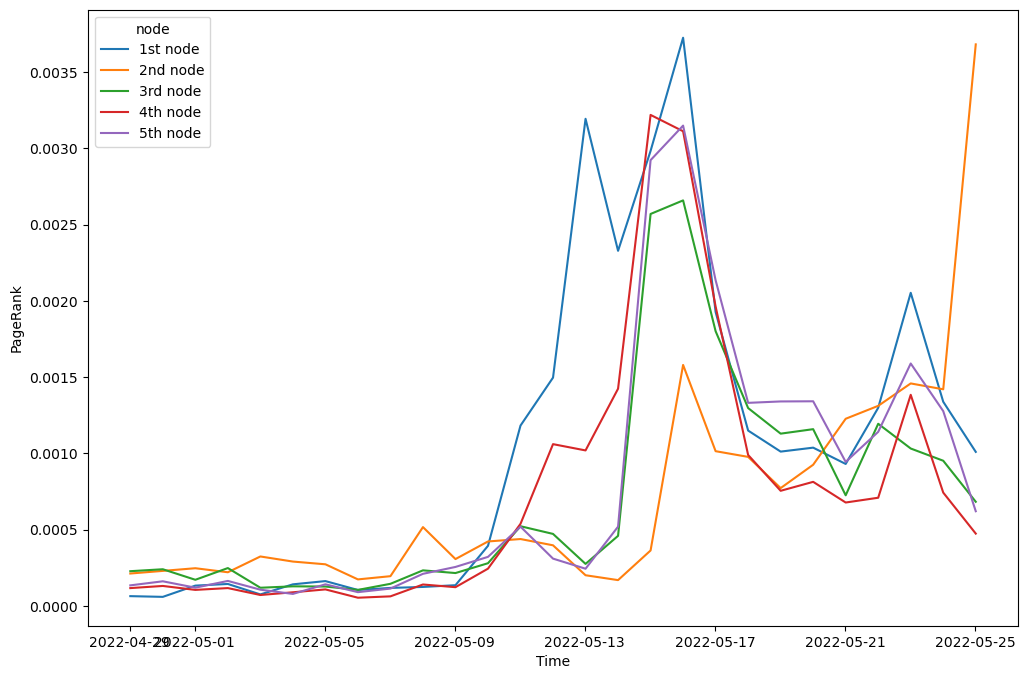

In [18]:
g = rty.graph_loader.stable_coin_graph("/data-restricted/home/cheick_ba/data_on_nas/raphtory/data/stablecoin_test/", subset=True)
layer_graph = g.layer("LUNC")
pg = rty.algorithms.pagerank(g = layer_graph, iter_count=10)
top_5_nodes = get_top_k_nodes(metric_dict = pg, k = 5)

graph_views = layer_graph.rolling(window='1 day', step = "1 day") 
for viewG in graph_views:
    time = viewG.end_date_time()
    values = dict(rty.algorithms.pagerank(g=viewG, iter_count = 10))
    for i,n in enumerate(top_5_nodes):
        metric_list.append( (time, values[n], f"{order_formatter(i+1)} node" ) ) 

plotting_function(metric_list, x="Time", y="PageRank", hue="node")

# Temporal motifs example

In [70]:
graph_views = G.rolling(window='1 month', step = "1 month")

metric_func = algorithms.pagerank
metric_list = []

total = sum([ 1 for w in graph_views])
print("Number of graph views", total )
print("If we consider layers, total number of rows should be", sum([ 1 for w in graph_views]) * len(all_layers))

for viewG in tqdm(graph_views, total=total) :
    time = viewG.end_date_time()
    
    for l in all_layers:
        viewG_l = viewG.layer(l)
        metric_val = metric_func(viewG_l)
        metric_rolling.append( (time, metric_val,l) )        

Number of graph views 57
If we consider layers, total number of rows should be 912


100%|██████████| 57/57 [10:13<00:00, 10.76s/it]


In [9]:
for l in all_layers:
    print("Contract address {} has 0x28c6c06298d514db089934071355e5743bf21d60? {}".format(l, g.layer(l).has_vertex("0x28c6c06298d514db089934071355e5743bf21d60")))

Contract address Dai has 0x28c6c06298d514db089934071355e5743bf21d60? True
Contract address LUNC has 0x28c6c06298d514db089934071355e5743bf21d60? True
Contract address USTC has 0x28c6c06298d514db089934071355e5743bf21d60? True
Contract address USD has 0x28c6c06298d514db089934071355e5743bf21d60? True
Contract address USDP has 0x28c6c06298d514db089934071355e5743bf21d60? True
Contract address USDT has 0x28c6c06298d514db089934071355e5743bf21d60? True


In [10]:
for l in all_layers:
    print("Contract address {} has 0x74de5d4fcbf63e00296fd95d33236b9794016631? {}".format(l, g.layer(l).has_vertex("0x74de5d4fcbf63e00296fd95d33236b9794016631")))

Contract address Dai has 0x74de5d4fcbf63e00296fd95d33236b9794016631? True
Contract address LUNC has 0x74de5d4fcbf63e00296fd95d33236b9794016631? True
Contract address USTC has 0x74de5d4fcbf63e00296fd95d33236b9794016631? True
Contract address USD has 0x74de5d4fcbf63e00296fd95d33236b9794016631? True
Contract address USDP has 0x74de5d4fcbf63e00296fd95d33236b9794016631? True
Contract address USDT has 0x74de5d4fcbf63e00296fd95d33236b9794016631? True


In [11]:
for l in all_layers:
    pg = algorithms.pagerank(g.layer(l), 20)
    sorted_pg = dict(sorted(pg.items(), key=lambda x: x[1], reverse=True))
    print("Important people from contract address {}: {}".format(l, list(sorted_pg.items())[:10]))
    print()

Done running iterations: 1
Important people from contract address Dai: [('0x503828976d22510aad0201ac7ec88293211d23da', 0.0021117792682171037), ('0x28c6c06298d514db089934071355e5743bf21d60', 0.002109268326748625), ('0x74de5d4fcbf63e00296fd95d33236b9794016631', 0.001314686215381458), ('0x60594a405d53811d3bc4766596efd80fd545a270', 0.0009343411267338441), ('0x5777d92f208679db4b9778590fa3cab3ac9e2168', 0.0007376593290049379), ('0xa12431d0b9db640034b0cdfceef9cce161e62be4', 0.0005977745605573248), ('0x0000000000000000000000000000000000000000', 0.0005557580661770019), ('0x2faf487a4414fe77e2327f0bf4ae2a264a776ad2', 0.0004938959820280982), ('0xa478c2975ab1ea89e8196811f51a7b7ade33eb11', 0.00046649946263294117), ('0x66c57bf505a85a74609d2c83e94aabb26d691e1f', 0.0004587428014694163)]

Done running iterations: 1
Important people from contract address LUNC: [('0x77696bb39917c91a0c3908d577d5e322095425ca', 0.0021130216887443654), ('0x0000000000000000000000000000000000000000', 0.001041933171094226), ('0x

In [12]:
luna = g.layer("LUNC")

In [13]:
pg = algorithms.pagerank(luna, 20)

Done running iterations: 1


In [14]:
pg["0x0000000000000000000000000000000000000000"]

0.001041933171094226

In [15]:
for l in all_layers:
    for w in g.layer(l).rolling(step='1 day', window='1 day'):
        print("dt_time {}, Date {}, Contract address {} has {} transactions".format(datetime.fromtimestamp(w.start() / 1000), w.start_date_time(), l,w.layer(l).num_edges()))

dt_time 2022-04-28 02:30:15, Date 2022-04-28 00:30:15, Contract address Dai has 4691 transactions
dt_time 2022-04-29 02:30:15, Date 2022-04-29 00:30:15, Contract address Dai has 5237 transactions
dt_time 2022-04-30 02:30:15, Date 2022-04-30 00:30:15, Contract address Dai has 4828 transactions
dt_time 2022-05-01 02:30:15, Date 2022-05-01 00:30:15, Contract address Dai has 4266 transactions
dt_time 2022-05-02 02:30:15, Date 2022-05-02 00:30:15, Contract address Dai has 4504 transactions
dt_time 2022-05-03 02:30:15, Date 2022-05-03 00:30:15, Contract address Dai has 4354 transactions
dt_time 2022-05-04 02:30:15, Date 2022-05-04 00:30:15, Contract address Dai has 5202 transactions
dt_time 2022-05-05 02:30:15, Date 2022-05-05 00:30:15, Contract address Dai has 5336 transactions
dt_time 2022-05-06 02:30:15, Date 2022-05-06 00:30:15, Contract address Dai has 5475 transactions
dt_time 2022-05-07 02:30:15, Date 2022-05-07 00:30:15, Contract address Dai has 5263 transactions
dt_time 2022-05-08 0

In [16]:
events = [['2022-05-12', 'LUNA Crash']]
events = pd.DataFrame(events, columns=['Time', 'event'])
event_rules = alt.Chart(events).mark_rule(color='gray').encode(x='Time:T')
labels = alt.Chart(events).mark_text(dx=3, dy=-120, color='black', align='left').encode(
    x='Time:T',
    text='event'
)
event_chart = alt.layer(event_rules, labels)

In [17]:
result = pd.DataFrame()

all_layers = g.get_unique_layers()
avoid_layers = ['USD', 'USDT']
layers = set(all_layers) - set(avoid_layers)

rolling = g.rolling(step='1 day', window='1 day')
for l in layers:
    result[l] = [w.layer(l).num_edges() for w in rolling]

result['Time'] = [w.end_date_time() for w in rolling]

source = pd.melt(result, id_vars=['Time'], value_vars=layers, var_name='Layer', value_name='Tnx Count')
selection = alt.selection_multi(fields=['layer'], bind='legend')
chart = alt.Chart(source).mark_line().encode(
    x="Time:T",
    y=f"{'Tnx Count'}:Q",
    color="Layer",
    tooltip=['Layer', 'Tnx Count'],
    opacity=alt.condition(selection, alt.value(1.0), alt.value(0.2))
).properties(
    width=800,
).add_selection(
    selection
)

alt.layer(chart, event_chart)

/data-restricted/home/cheick_ba/.conda/envs/raphtory/lib/python3.10/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/data-restricted/home/cheick_ba/.conda/envs/raphtory/lib/python3.10/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.LayerChart(...)

In [18]:
result = pd.DataFrame()
all_layers = g.get_unique_layers()
avoid_layers = ['USD', 'USDT']
layers = set(all_layers) - set(avoid_layers)

rolling = g.rolling(step='1 day', window='1 week')
for l in layers:
    result[l] = [w.layer(l).num_edges() for w in rolling]

result['Time'] = [w.end_date_time() for w in rolling]

source = pd.melt(result, id_vars=['Time'], value_vars=layers, var_name='Layer', value_name='Tnx Count')
selection = alt.selection_multi(fields=['Layer'], bind='legend')
chart = alt.Chart(source).mark_line().encode(
    x="Time:T",
    y=f"{'Tnx Count'}:Q",
    color="Layer",
    tooltip=['Layer', 'Tnx Count'],
    opacity=alt.condition(selection, alt.value(1.0), alt.value(0.2))
).properties(
    width=800,
).add_selection(
    selection
)

alt.layer(chart, event_chart)

/data-restricted/home/cheick_ba/.conda/envs/raphtory/lib/python3.10/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'selection_multi' is deprecated.  Use 'selection_point'
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)
/data-restricted/home/cheick_ba/.conda/envs/raphtory/lib/python3.10/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.LayerChart(...)

In [19]:
result = pd.DataFrame()

rolling = g.rolling(step='1 day', window='1 week')

result['Tnx Count'] = [w.layer('LUNC').num_edges() for w in rolling]
result['Time'] = [w.layer('LUNC').end_date_time() for w in rolling]

chart = alt.Chart(result).mark_line().encode(
    x="Time:T",
    y="Tnx Count:Q",
).properties(
    width=800,
).add_selection(
    selection
)

alt.layer(chart, event_chart)

/data-restricted/home/cheick_ba/.conda/envs/raphtory/lib/python3.10/site-packages/altair/utils/deprecation.py:65: AltairDeprecationWarning: 'add_selection' is deprecated. Use 'add_params' instead.
  warnings.warn(message, AltairDeprecationWarning, stacklevel=1)


alt.LayerChart(...)

In [23]:
for w in rolling:
    algorithms.pagerank(w.layer('LUNC'), 20)["0xd30b438df65f4f788563b2b3611bd6059bff4ad9"] 

Done running iterations: 1
Done running iterations: 1
Done running iterations: 1
Done running iterations: 1
Done running iterations: 1
Done running iterations: 1
Done running iterations: 1


thread '<unnamed>' panicked at 'index out of bounds: the len is 434423 but the index is 434423', /data-restricted/home/cheick_ba/src/raphtory/raphtory/src/db/task/task_runner.rs:214:13


PanicException: index out of bounds: the len is 434423 but the index is 434423

In [31]:
print(w)

Graph(number_of_edges=698767, number_of_vertices=434423, earliest_time=1651192215000, latest_time=1651797015000)


In [30]:
pr = algorithms.pagerank(w, 20)

thread '<unnamed>' panicked at 'index out of bounds: the len is 434423 but the index is 434423', /data-restricted/home/cheick_ba/src/raphtory/raphtory/src/db/task/task_runner.rs:214:13


PanicException: index out of bounds: the len is 434423 but the index is 434423

In [20]:
result = pd.DataFrame()

rolling = g.rolling(step='1 day', window='1 week')

result['Page Rank'] = [algorithms.pagerank(w.layer('LUNC'), 20)["0xd30b438df65f4f788563b2b3611bd6059bff4ad9"] for w in rolling]
result['Time'] = [w.layer('LUNC').end_date_time() for w in rolling]

chart = alt.Chart(result).mark_line().encode(
    x="Time:T",
    y="Page Rank:Q",
).properties(
    width=800,
)

alt.layer(chart, event_chart)

Done running iterations: 1
Done running iterations: 1
Done running iterations: 1
Done running iterations: 1
Done running iterations: 1
Done running iterations: 1
Done running iterations: 1


thread '<unnamed>' panicked at 'index out of bounds: the len is 434423 but the index is 434423', /data-restricted/home/cheick_ba/src/raphtory/raphtory/src/db/task/task_runner.rs:214:13
note: run with `RUST_BACKTRACE=1` environment variable to display a backtrace


PanicException: index out of bounds: the len is 434423 but the index is 434423

In [21]:
result = pd.DataFrame()

layers = g.get_unique_layers()
rolling = g.rolling(step='1 day', window='1 week')

for l in layers:
    result[l] = [algorithms.pagerank(w.layer(l), 20)["0x503828976d22510aad0201ac7ec88293211d23da"] for w in rolling]

result['Time'] = [w.end_date_time() for w in rolling]

source = pd.melt(result, id_vars=['Time'], value_vars=layers, var_name='Layer', value_name='Page Rank')
selection = alt.selection_multi(fields=['Layer'], bind='legend')

chart = alt.Chart(source).mark_line().encode(
    x="Time:T",
    y=f"{'Page Rank'}:Q",
    color="Layer",
    tooltip=['Layer', 'Page Rank'],
    opacity=alt.condition(selection, alt.value(1.0), alt.value(0.2))
).properties(
    width=800,
).add_selection(
    selection
)

alt.layer(chart, event_chart)

Done running iterations: 1
Done running iterations: 1
Done running iterations: 1
Done running iterations: 1
Done running iterations: 1
Done running iterations: 1
Done running iterations: 1


thread '<unnamed>' panicked at 'index out of bounds: the len is 434423 but the index is 434423', /data-restricted/home/cheick_ba/src/raphtory/raphtory/src/db/task/task_runner.rs:214:13


PanicException: index out of bounds: the len is 434423 but the index is 434423